#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/wbc.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df.iloc[:-1,:]
df.tail()


,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
5746,27/07/2022,21.100000,21.530001,21.049999,21.41,21.41,5459593.0,1.35,2.5,125.0
5747,28/07/2022,21.610001,21.650000,21.410000,21.43,21.43,5165682.0,1.35,2.5,125.0
5748,29/07/2022,21.510000,21.600000,21.469999,21.51,21.51,7000330.0,1.35,2.5,125.0
5749,1/08/2022,21.500000,21.660000,21.230000,21.66,21.66,6824049.0,1.35,2.5,125.0
5750,2/08/2022,21.610001,22.020000,21.559999,22.00,22.00,6402716.0,1.35,2.5,125.0


In [3]:
#Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# # Drop all previous records now in MongoDb
# db.wbc.drop()

# # Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.wbc.insert_many(records)

In [4]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.wbc.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.wbc.delete_one(
    {'Date': last_date}
)

DELETE: 2/08/2022 22.0


In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.wbc.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

NEW LAST VALUE IN MONGODB: 1/08/2022 21.66


In [6]:
from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

Previous last date in MongoDb: 01-08-2022. Today's date: 03-08-2022


In [7]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'WBC.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-01,21.66,21.230000,21.500000,21.66,6824049,21.66
2022-08-02,22.02,21.559999,21.610001,22.00,6402716,22.00


In [8]:
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-02,22.02,21.559999,21.610001,22.0,6402716,22.0


In [9]:
tot=len(stock_quote)
rba=1.35
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)

#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)

stock_quote

C:\Users\antoi\AppData\Local\Temp/ipykernel_5904/186301538.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
C:\Users\antoi\AppData\Local\Temp/ipykernel_5904/186301538.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
C:\Users\antoi\AppData\Local\Temp/ipykernel_5904/186301538.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,02/08/2022,22.02,21.559999,21.610001,22.0,6402716,22.0,1.35,2.5,125


In [10]:
records=stock_quote.to_dict('records')
records

[{'Date': '02/08/2022',
  'High': 22.020000457763672,
  'Low': 21.559999465942383,
  'Open': 21.610000610351562,
  'Close': 22.0,
  'Volume': 6402716,
  'Adj Close': 22.0,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125}]

In [11]:
#INSERT NEW DATA INTO MONGODB
db.wbc.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.wbc.find()))

last_val = df_mongo.iloc[-20:].values
print(last_val)

[[ObjectId('62e9a5e7ce9f5043b5bafdbe') '6/07/2022' 19.700001 20.0 19.6
  19.85 19.85 8508166.0 1.35 1.75 125.0]
 [ObjectId('62e9a5e7ce9f5043b5bafdbf') '7/07/2022' 19.860001 20.0
  19.719999 20.0 20.0 5529932.0 1.35 1.75 125.0]
 [ObjectId('62e9a5e7ce9f5043b5bafdc0') '8/07/2022' 20.059999 20.120001
  19.915001 19.950001 19.950001 4255108.0 1.35 1.75 125.0]
 [ObjectId('62e9a5e7ce9f5043b5bafdc1') '11/07/2022' 19.969999 20.139999
  19.790001 19.940001 19.940001 4086683.0 1.35 1.75 125.0]
 [ObjectId('62e9a5e7ce9f5043b5bafdc2') '12/07/2022' 20.17 20.17 19.92
  20.1 20.1 6550625.0 1.35 1.75 125.0]
 [ObjectId('62e9a5e7ce9f5043b5bafdc3') '13/07/2022' 20.190001 20.200001
  19.955 20.16 20.16 6624638.0 1.35 1.75 125.0]
 [ObjectId('62e9a5e7ce9f5043b5bafdc4') '14/07/2022' 19.93 20.040001
  19.790001 19.940001 19.940001 5781973.0 1.35 1.75 125.0]
 [ObjectId('62e9a5e7ce9f5043b5bafdc5') '15/07/2022' 19.83 19.9 19.52 19.9
  19.9 5555754.0 1.35 1.75 125.0]
 [ObjectId('62e9a5e7ce9f5043b5bafdc6') '18/07/20

In [13]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

02/08/2022 22.0


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [14]:
df_mongo = pd.DataFrame(list(db.wbc.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()

# # # del data[0]
len_df_mongo=len(df_mongo)

data = df_mongo.filter(["Close"])
dataset=data.values
dataset

array([[10.435952],
       [10.240284],
       [10.051568],
       ...,
       [21.51    ],
       [21.66    ],
       [22.      ]])

In [15]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape

In [16]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4575, 1)

In [17]:
last60=train_data[60:]
print(last60)

[[0.01077541]
 [0.01007048]
 [0.01342732]
 ...
 [0.70494453]
 [0.70900019]
 [0.70629644]]


In [18]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.01366231, 0.00704935, 0.00067134, 0.        , 0.        ,
       0.00359179, 0.00386034, 0.00402818, 0.00704935, 0.01208457,
       0.02181938, 0.02249075, 0.01812687, 0.01879824, 0.01376299,
       0.01342732, 0.01208457, 0.01208457, 0.01715339, 0.0234978 ,
       0.01819402, 0.01376299, 0.01678415, 0.02282646, 0.02205437,
       0.02551192, 0.02745885, 0.03625377, 0.03289693, 0.02181938,
       0.01913391, 0.01544141, 0.01074185, 0.00268546, 0.        ,
       0.00167842, 0.        , 0.00268546, 0.00201409, 0.01342732,
       0.00201409, 0.01007048, 0.02239004, 0.01611278, 0.01040615,
       0.01040615, 0.01054042, 0.01342732, 0.0234978 , 0.02685463,
       0.02282646, 0.02249075, 0.02685463, 0.02886872, 0.02685463,
       0.0177912 , 0.01443436, 0.01611278, 0.00738502, 0.01510574])]
[0.010775413823760738]


# Prepare train data for LSTM model

In [19]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4515, 60)

In [20]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4515, 60, 1)

# Build the LSTM model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [22]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4515/4515 [==============================] - 76s 17ms/step - loss: 0.0011


In [24]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [25]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [26]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [27]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.045425165147943265

C:\Users\antoi\AppData\Local\Temp/ipykernel_5904/2123730201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


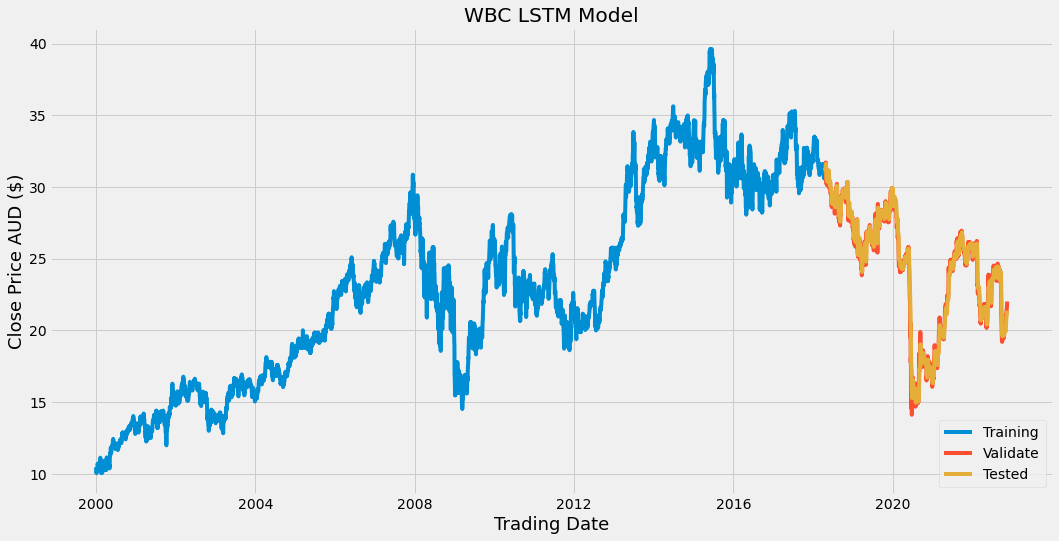

In [28]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('WBC LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/wbc_graph.png')
plt.show()

# Test data Predictions on the Model

In [29]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_5904/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4575,31.110001,31.151566,-0.041565
4576,30.980000,31.235849,-0.255849
4577,30.959999,31.228739,-0.268740
4578,31.420000,31.187901,0.232099
4579,31.700001,31.349754,0.350247
...,...,...,...
5713,21.410000,20.938324,0.471676
5714,21.430000,21.079044,0.350956
5715,21.510000,21.183275,0.326725
5716,21.660000,21.266521,0.393479


In [30]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.wbc.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [31]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [32]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

02/08/2022 Last close $22.0 Predicted next day share price $21.24


# Save the Model

In [33]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/wbc_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list wbc_sixty and load df

#PREDICT USING LOADED MODEL

In [34]:
from keras.models import load_model
model_in = load_model('../static/wbc_model.sav')

In [35]:

# query the wbc collection and load into dataframe
import pandas as pd

df_mongo = pd.DataFrame(list(db.wbc.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[24.35      ],
       [24.129999  ],
       [23.76      ],
       [23.66      ],
       [24.1       ],
       [24.41      ],
       [24.360001  ],
       [23.370001  ],
       [23.35      ],
       [23.360001  ],
       [23.4       ],
       [23.620001  ],
       [23.9       ],
       [23.950001  ],
       [24.040001  ],
       [23.809999  ],
       [23.98      ],
       [23.83      ],
       [23.875     ],
       [23.85      ],
       [23.41      ],
       [21.959999  ],
       [21.030001  ],
       [20.85      ],
       [19.26      ],
       [19.65      ],
       [19.280001  ],
       [18.799999  ],
       [19.129999  ],
       [19.209999  ],
       [19.440001  ],
       [19.620001  ],
       [19.290001  ],
       [19.799999  ],
       [19.620001  ],
       [19.620001  ],
       [19.5       ],
       [19.42      ],
       [19.615     ],
       [19.465     ],
       [19.6       ],
       [19.719999  ],
       [19.915001  ],
       [19.790001  ],
       [19.92      ],
       [19

#Create a function to loop through the days input

In [36]:
from keras.models import load_model
model_in = load_model('../static/wbc_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_wbc(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_wbc(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[21.28,
 21.25,
 21.19,
 21.13,
 21.07,
 21.03,
 20.99,
 20.97,
 20.96,
 20.95,
 20.95,
 20.96,
 20.96,
 20.97,
 20.98,
 20.99,
 21.0,
 21.0,
 21.01,
 21.01,
 21.02,
 21.03,
 21.04,
 21.05,
 21.06,
 21.07,
 21.08,
 21.08,
 21.09,
 21.09,
 21.1,
 21.1,
 21.11,
 21.11,
 21.11,
 21.12,
 21.12,
 21.12,
 21.13,
 21.13,
 21.14,
 21.14,
 21.15,
 21.15,
 21.16,
 21.16,
 21.17,
 21.17,
 21.17,
 21.18,
 21.17,
 21.17,
 21.17,
 21.17,
 21.16,
 21.16,
 21.16,
 21.16,
 21.16,
 21.16,
 21.16,
 21.16,
 21.16,
 21.16,
 21.16,
 21.17,
 21.17,
 21.17,
 21.17,
 21.17,
 21.17,
 21.17,
 21.17,
 21.17,
 21.17,
 21.17,
 21.17,
 21.17,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.18,
 21.

In [37]:
import pandas as pd
dates_df = pd.read_csv("../static/data/dates.csv")
dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
dates_df

,Count,Date,DOW
0,1,11/07/2022,Monday
1,2,12/07/2022,Tuesday
2,3,13/07/2022,Wednesday
3,4,14/07/2022,Thursday
4,5,15/07/2022,Friday
...,...,...,...
260,261,10/07/2023,Monday
261,262,11/07/2023,Tuesday
262,263,12/07/2023,Wednesday
263,264,13/07/2023,Thursday


C:\Users\antoi\AppData\Local\Temp/ipykernel_5904/2095352370.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


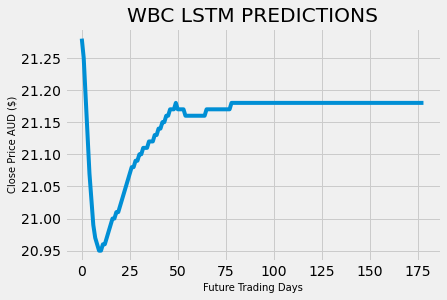

In [38]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:input-1]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('WBC LSTM PREDICTIONS')
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.savefig('../static/data/images/pred/wbc_pred.png', bbox_inches="tight")
plt.show()

In [39]:
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 21.28},
 {'Price': 21.25},
 {'Price': 21.19},
 {'Price': 21.13},
 {'Price': 21.07},
 {'Price': 21.03},
 {'Price': 20.99},
 {'Price': 20.97},
 {'Price': 20.96},
 {'Price': 20.95},
 {'Price': 20.95},
 {'Price': 20.96},
 {'Price': 20.96},
 {'Price': 20.97},
 {'Price': 20.98},
 {'Price': 20.99},
 {'Price': 21.0},
 {'Price': 21.0},
 {'Price': 21.01},
 {'Price': 21.01},
 {'Price': 21.02},
 {'Price': 21.03},
 {'Price': 21.04},
 {'Price': 21.05},
 {'Price': 21.06},
 {'Price': 21.07},
 {'Price': 21.08},
 {'Price': 21.08},
 {'Price': 21.09},
 {'Price': 21.09},
 {'Price': 21.1},
 {'Price': 21.1},
 {'Price': 21.11},
 {'Price': 21.11},
 {'Price': 21.11},
 {'Price': 21.12},
 {'Price': 21.12},
 {'Price': 21.12},
 {'Price': 21.13},
 {'Price': 21.13},
 {'Price': 21.14},
 {'Price': 21.14},
 {'Price': 21.15},
 {'Price': 21.15},
 {'Price': 21.16},
 {'Price': 21.16},
 {'Price': 21.17},
 {'Price': 21.17},
 {'Price': 21.17},
 {'Price': 21.18},
 {'Price': 21.17},
 {'Price': 21.17},
 {'Price': 21.17

In [40]:
# DRAW THE PREDICTION
# df_len = len(df.index) # length of the original dataframe
len_df_mongo = len(df_mongo.index) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,len_df_mongo,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4575 5718 5898


,Close
5887,21.18
5888,21.18
5889,21.18
5890,21.18
5891,21.18
5892,21.18
5893,21.18
5894,21.18
5895,21.18
5896,21.18


In [41]:
len_df_mongo = len(df_mongo.index) # length of the original dataframe
print(train_data_len,len(df_mongo),train_data_len-5886,4569/5886,len_df_mongo)

4575 5718 -1311 0.7762487257900101 5718


C:\Users\antoi\AppData\Local\Temp/ipykernel_5904/1661865422.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


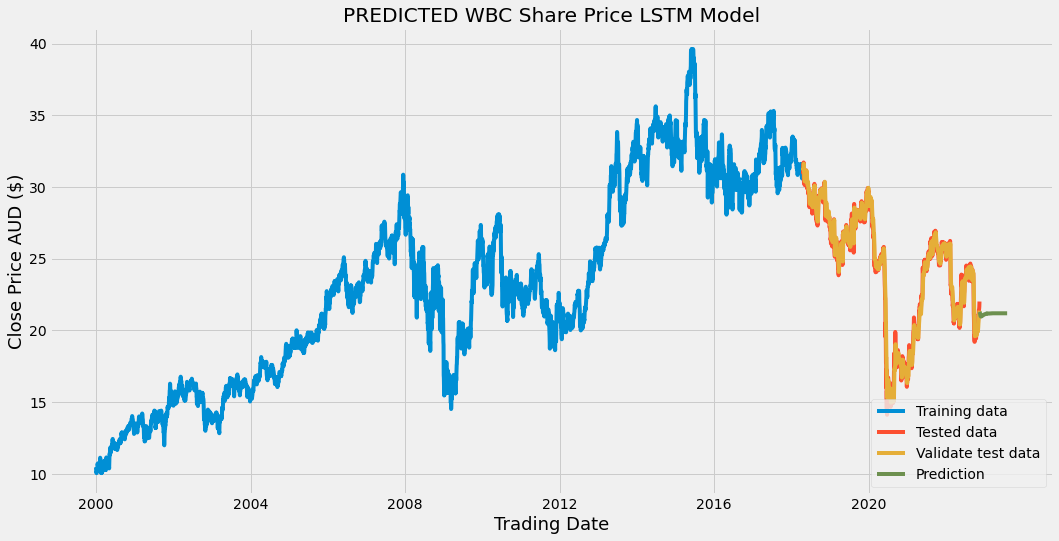

In [42]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTED WBC Share Price LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/wbc_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [43]:
# Query all
name = 'WBC'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)


{'_id': ObjectId('62e22127c7e5ff501a0a119c'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/07/2022', 'predicted': 20.96, 'actual': 21.47, 'differece': -0.509999999999998, 'rmse': 0.17596}
{'_id': ObjectId('62e230eafd3e48eabe9b8365'), 'model': 'RFR', 'name': 'WBC', 'date': '28/07/2022', 'predicted': 31, 'actual': 21, 'differece': 10.425907785164608, 'accuracy': 97.16}


In [44]:
# Delete a document from a collection
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e230eafd3e48eabe9b8365'), 'model': 'RFR', 'name': 'WBC', 'date': '28/07/2022', 'predicted': 31, 'actual': 21, 'differece': 10.425907785164608, 'accuracy': 97.16}


In [45]:
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close

print(f'date {last_date}, predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 02/08/2022, predicted $21.24, actual $22.0, difference -0.7600000000000016, rmse 0.04543


In [46]:
# Insert a document into the 'companys' collection
db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'differece': difference,
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62e230eafd3e48eabe9b8365'), 'model': 'RFR', 'name': 'WBC', 'date': '28/07/2022', 'predicted': 31, 'actual': 21, 'differece': 10.425907785164608, 'accuracy': 97.16}
{'_id': ObjectId('62e9a652ce9f5043b5bafdd3'), 'model': 'LSTM', 'name': 'WBC', 'date': '02/08/2022', 'predicted': 21.24, 'actual': 22.0, 'differece': -0.7600000000000016, 'rmse': 0.04543}


In [47]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62df8ae0427af058c4334ede'), 'model': 'RFR', 'name': 'CBA', 'date': '26/07/2022', 'predicted': 97, 'actual': 96, 'differece': 1.0204273335669143, 'accuracy': 97.43}
{'_id': ObjectId('62dfa392f178c5283b8b5648'), 'model': 'RFR', 'name': 'MIN', 'date': '22/07/2022', 'predicted': 38, 'actual': 46, 'differece': -7.74920083942115, 'accuracy': 93.63}
{'_id': ObjectId('62dfa4d3643d249dfcfea5f3'), 'model': 'RFR', 'name': 'NAB', 'date': '26/07/2022', 'predicted': 28, 'actual': 29, 'differece': -0.9521357946721061, 'accuracy': 97.23}
{'_id': ObjectId('62e223a5553c4e8d8e53f30a'), 'model': 'LSTM', 'name': 'NHC', 'date': '28/07/2022', 'predicted': 4, 'actual': 4.4, 'differece': -0.15000000000000036, 'rmse': 0.04529}
{'_id': ObjectId('62e230eafd3e48eabe9b8365'), 'model': 'RFR', 'name': 'WBC', 'date': '28/0